## Introduction

This notebook simulates freight trips and generates a freight population file.

The following steps are undertaken:

1. Read, process, and plot data.
2. Input Assumptions & Sampler Creation
3. Create Activity Model & Population
4. Validation

In [1]:
import pandas as pd
import geopandas as gp
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt
import random
from datetime import date
import numpy as np
from shapely.geometry import Point, Polygon
import os
import scipy
from scipy import spatial


import pam
from pam.core import Population, Household, Person
from pam import read
from pam.plot.stats import plot_activity_times, plot_leg_times

import pam.samplers
from pam.samplers.spatial import RandomPointSampler
from pam.samplers.facility import FacilitySampler
from pam.samplers import facility
from pam.samplers import tour

from pam import write
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices


matplotlib.style.use('ggplot')

In [2]:
output_path = './data/outputs'

## 1. Read, process, plot Data
Loading in necessary from data register. In this case, zones and freight facility data.

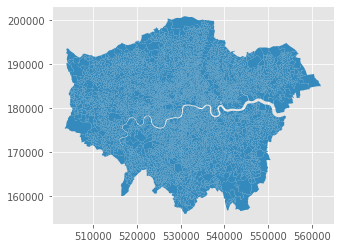

In [3]:
zones = gp.read_file('./data/lsoas/LSOA_2004_London_Low_Resolution.shp')
# we need to convert zones to a "m" grid crs to appropriately measure distances 
zones.set_crs('EPSG:27700', allow_override=True, inplace=True)
zones.rename(columns={'LSOA_CODE':'zone'}, inplace=True)
zones.plot()
plt.show()

<AxesSubplot:>

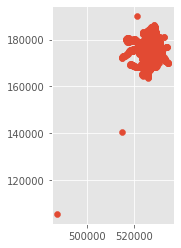

In [4]:
# load facilities
facilities = gp.read_file('./data/londinium_facilities_epsg_27700.geojson')
facilities.set_crs('EPSG:27700', allow_override=True, inplace=True)

# dummy create depots and deliveries
facilities['activity'] = np.where(facilities['activity']=='work', 'depot', facilities['activity'])
facilities['activity'] = np.where(facilities['activity']=='pub', 'delivery', facilities['activity'])

facilities.plot()

In [5]:
# crop zones df to Londinium zones only.
cols = list(zones.columns)

zones_londinium = gp.sjoin(zones, facilities, how='inner', predicate='intersects')
zones_londinium = zones_londinium[cols]
zones = zones_londinium.drop_duplicates()
#zones.head()

In [6]:
zones = zones.set_index('zone')

In [7]:
facility_sampler = FacilitySampler(
    facilities=facilities,
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True
)

facility_sampler.activities

Joining facilities data to zones, this may take a while.
/var/folders/fg/4rbdps2s6ss9r2455xhzwd4sswl1dp/T/ipykernel_10922/930579154.py:1: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

Building sampler, this may take a while.


['other',
 'park',
 'transit',
 'delivery',
 'shop',
 'depot',
 'medical',
 'education',
 'leisure',
 'home',
 'gym']

In [8]:
# Create a facility zone dataset to be used in samplers
facility_zone = gp.sjoin(facilities, zones, how='inner', predicate='intersects')
facility_zone.rename(columns={'index_right':'zone'}, inplace = True)
facility_zone.set_index('zone', inplace = True)

Using random sample for zone:E01003854:depot


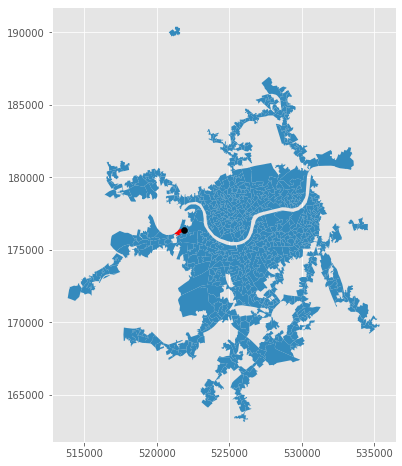

In [9]:
# Spider.
def plot_facility(zone_idx, activity):
    
    fig, ax = plt.subplots(figsize=(8,8))
    zones.plot(ax=ax)
    zones.loc[[zone_idx]].plot(color='red', ax=ax)
    
    facility_sampler.clear()
    point = facility_sampler.sample(zone_idx, activity)
    ax.scatter(point.x, point.y, color='black')
    plt.show()
    
plot_facility(random.choice(zones.index), 'depot')

## 2. Input Assumptions

#### Number of Stops & Stop Sampler
Build a Stop Number distribution and corresponding sampler.

In [10]:
bins = range(3,12)
pivots = {3: 36.0, 4: 28.0, 5: 15.0, 6: 7.0, 7: 4.0, 8: 2.5, 9: 2.5, 10: 1.0, 11: 4.0}
stop_sampler = tour.PivotDistributionSampler(bins=bins,pivots=pivots)
stop_sampler

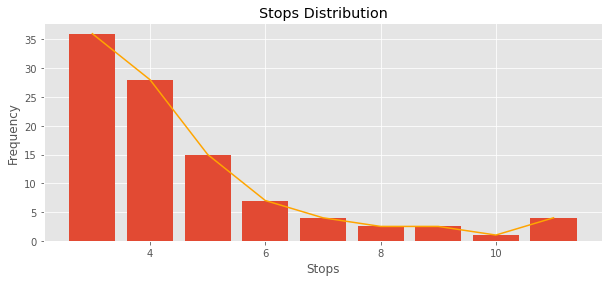

In [11]:
stop_sampler.plot(plot_title='Stops Distribution', x_label='Stops', y_label='Frequency')

#### Freight Tours & Distribution Sampler

In [12]:
# Set up freight params for both LGV and hgv movements

lgv_params = {'total':500000,
              'pivots': {7: 14, 8 :9, 9: 13, 10: 16, 11: 18, 12: 13, 13: 15, 14: 16, 15: 14, 16: 13, 17: 9, 18: 5, 19: 3, 20: 3, 21: 3, 22: 2},
              'agent_id': 'LGV',
              'agent_attributes': 'lgv'
              }

hgv_params = {'total':250000,
              'pivots': {7: 2, 8: 1, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 1, 18: 0, 19: 1, 20: 1, 21: 1, 22: 1},
              'agent_id': 'HGV',
              'agent_attributes': 'hgv'
              }

In [13]:
# We choose to create a population for LGV.
freight_params = lgv_params.copy()

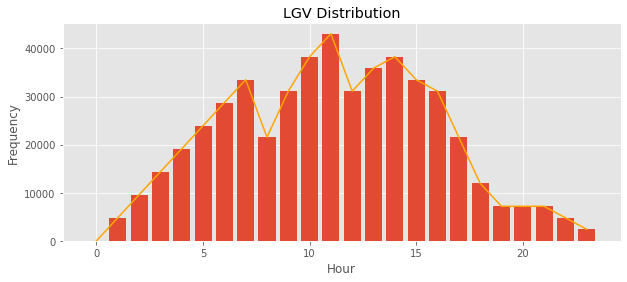

In [14]:
# Create LGV Distribution
bins = range(0,24)

hour_sampler = tour.PivotDistributionSampler(bins=bins, pivots=freight_params['pivots'], total=freight_params['total'])
hour_sampler.plot(plot_title=f"{freight_params['agent_id']} Distribution", x_label='Hour', y_label='Frequency')

In [15]:
# Create a minute sampler
minute_sampler = tour.FrequencySampler(range(60))
minute_sampler.sample()

51

#### Input Demand & Constraints
Calculate the density of depots and deliveries across all zones. Merge this with the zones table to obtain the geometry and calculate the distance between each zone.

In [16]:
origin_density = tour.create_density_gdf(facility_zone=facility_zone, zone=zones, activity=['depot'])
destination_density = tour.create_density_gdf(facility_zone=facility_zone, zone=zones, activity=['delivery'])

In [17]:
# Input Demand, in this case defined as facility density location
depot_sampler = tour.FrequencySampler(origin_density.index, origin_density.density)


In [18]:
# Constraint, defined as distance between origin and destination centroids. This dataframe will be filtered based on threshold values defined later.                                                                    
zones_list = zones.centroid.apply(lambda x: [x.x, x.y]).to_list()
od_matrix = spatial.distance_matrix(x=zones_list, y=zones_list)
df_od = pd.DataFrame(od_matrix, index=zones.index, columns=zones.index)
#df_od.head()

## 3. Activity Modeller

Assumptions and samplers are applied to build a population of activity plans.

Key assumptions of note:

- we take total demand from the hourly distribution and divide by 2 - this assumes a reciprocating return trip
- we create 2 activity types: depot and delivery
- we model depot departure time by sampling from hourly demand
- we aim to minimise activity beyond 24 hours as much as possible.

Activities are encoded as "car". Subpopulation is encoded as "lgv" or "hgv".

#### Population Parameters

In [19]:
#Factor to scale trips (To better match validation counts when needed)
factor = 1 #0.70

#List
#samples = [0.0001]
samples = [0.01]
#samples = [0.10]

# Set Distance threshold, in this case arbitrarily set to median distance of od dataframe.
threshold_value = df_od.median().agg('median')

In [20]:
# used for fnames
today = date.today().strftime('%d%b%y')
today

'31May22'

#### Activity Modeller

In [21]:
#### Sample Agents
def sample_agents(size):
    
    facility_sampler.clear()
    population = Population()
    
    # make below into an LGV/HGV function: freight_sampler.
    for i in range(size):

        agent_id = f"{freight_params['agent_id']}_{i}"

        # have to add hh to keep pam happy even though makes no sense in this case
        # might try to abstract this away in future
        hh = Household(agent_id)
        
        agent = Person(
            agent_id,
            attributes={
                'subpopulation': freight_params['agent_attributes'],
                'CarType': freight_params['agent_attributes'],
                'CarCO2': freight_params['agent_attributes']
            }
        )
        
        hh.add(agent)
        population.add(hh)

        hour = hour_sampler.sample()
        minute = minute_sampler.sample()

        if freight_params['agent_id']=='LGV':
            stops = stop_sampler.sample()
        else:
            stops = 1

        agent_plan = tour.TourPlanner(stops=stops,
                                      hour_sampler=hour,
                                      minute_sampler=minute,
                                      o_start='depot',
                                      o_sampler=depot_sampler,
                                      threshold_matrix=df_od,
                                      d_dist=destination_density,
                                      d_freq='density', 
                                      threshold_value=threshold_value, 
                                      facility_sampler=facility_sampler,
                                      activity_params={'o_activity':'depot', 'd_activity':'delivery'})
        
        o_zone, o_loc, d_zones, d_locs = agent_plan.sequence_stops()
        agent_plan.apply(agent=agent, o_zone=o_zone, o_loc=o_loc, d_zones=d_zones, d_locs=d_locs)
      
    return population


In [22]:
# Function to build population 

def build_population(sample, factor):
    population = sample_agents(int(factor * int(freight_params['total'] * sample)))
    
    return population

In [23]:
# Build + Crop + Write Population for samples
for s in samples:
    
    #build
    population = build_population(s, factor)
        
    #Crop and Validate Plans
    population.fix_plans()
    population.validate()

    # Write to Disk
    xml_comment = f"prelim {s*100}% {freight_params['agent_id']} {today}"
    output_path = os.path.join(output_path)
    
    write_matsim(
        population,
        os.path.join(output_path, "plans.xml"),
        os.path.join(output_path, "attributes.xml"),
        comment=xml_comment
    )

    population.to_csv(output_path, crs = "EPSG:27700", to_crs="EPSG:4326")
    # ignore all the "failed to find home" logging (it is not relevant and will be removed in future)

    facility_sampler.write_facilities_xml(
       os.path.join(output_path, "facilities.xml"),
       comment=xml_comment
    )

Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending 

## 4. Validation

Person: LGV_96
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_96'}
0:	Activity(1 act:depot, location:POINT (529547.2861600695 175331.6803329125), time:00:00:00 --> 13:20:00, duration:13:20:00)
1:	Leg(1 mode:car, area:POINT (529547.2861600695 175331.6803329125) --> POINT (524843.5870630894 177943.13910180677), time:13:20:00 --> 13:31:00, duration:0:11:00)
2:	Activity(2 act:delivery, location:POINT (524843.5870630894 177943.13910180677), time:13:31:00 --> 13:42:00, duration:0:11:00)
3:	Leg(2 mode:car, area:POINT (524843.5870630894 177943.13910180677) --> POINT (524433.7128327661 176051.65040089356), time:13:42:00 --> 13:52:00, duration:0:10:00)
4:	Activity(3 act:delivery, location:POINT (524433.7128327661 176051.65040089356), time:13:52:00 --> 14:02:00, duration:0:10:00)
5:	Leg(3 mode:car, area:POINT (524433.7128327661 176051.65040089356) --> POINT (524432.0121362873 175985.80048795152), time:14:02:00 --> 14:12:00, duration:0:10:00)
6:	Activity(4 act:delivery, lo

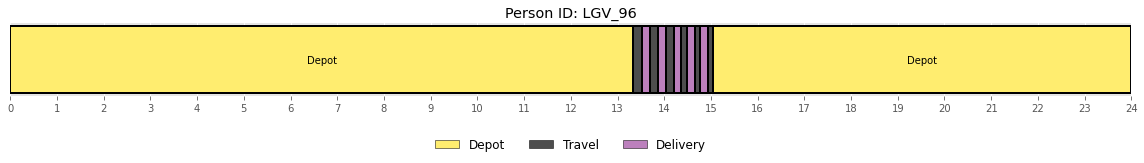

In [24]:
for i in range(1):
    p = population.random_person()
    p.plot()
    p.print()
    plt.show()

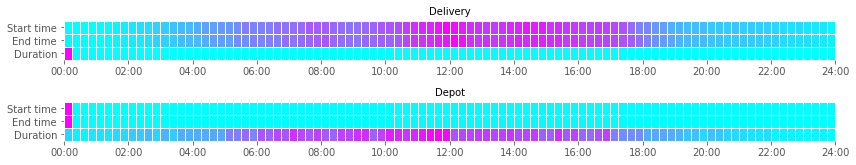

In [25]:
from pam.plot.stats import plot_activity_times, plot_leg_times
fig = plot_activity_times(population)
plt.show()

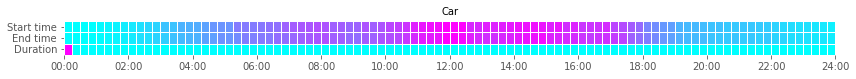

In [26]:
fig = plot_leg_times(population)
plt.show()

In [27]:
trips = pd.read_csv(os.path.join(output_path,"legs.csv"))

def get_hour(dt):
    return int(dt.split(" ")[1].split(":")[0])

trips["start_hour"] = trips["tst"].apply(get_hour)
#trips.head()

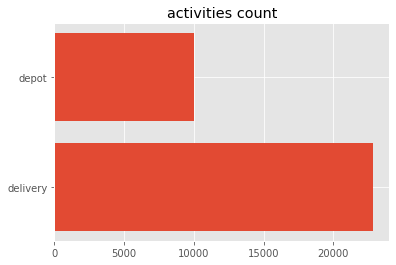

In [28]:
df_activity = pd.read_csv(os.path.join(output_path, "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")
plt.show()

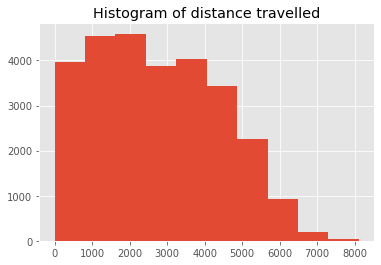

In [29]:
# Validate distance travelled
df_legs = gp.read_file(os.path.join(output_path, 'legs.geojson'))
df_legs.to_crs('EPSG:27700', inplace=True)
df_legs['length'] = df_legs.geometry.length

plt.hist(x='length', data=df_legs)
plt.title("Histogram of distance travelled")
plt.show()

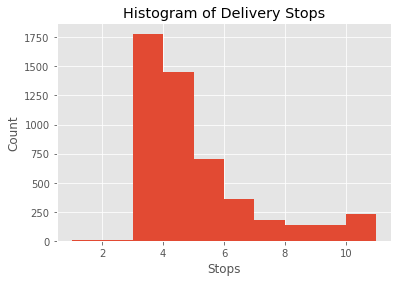

In [30]:
matplotlib.style.use('ggplot')

plot_data = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
g = plt.hist(x = 'activity', data = plot_data)

plt.title('Histogram of Delivery Stops')
plt.xlabel('Stops')
plt.ylabel('Count')

plt.show()

In [31]:
delivery_count = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
depot_count = df_activity[df_activity['activity']=='depot'].groupby(['pid']).agg({'activity':'count'}).reset_index()
print(f'Ratio of deliveries to depots {delivery_count.activity.sum()/depot_count.activity.sum()}')
delivery_count.describe()

Ratio of deliveries to depots 2.2927733787711735


,activity
count,4990.000000
mean,4.584168
std,2.012994
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,11.000000


In [32]:
write_od_matrices(population, path = output_path)
od_matrices = pd.read_csv(os.path.join(output_path, "total_od.csv")) 

In [33]:
freight_density = tour.ValidateTourOD(trips=trips,
                                      zone=zones,
                                      o_dist=origin_density,
                                      d_dist=destination_density,
                                      o_activity='depot',
                                      d_activity='delivery',
                                      o_freq='density',
                                      d_freq='density'
                                      )

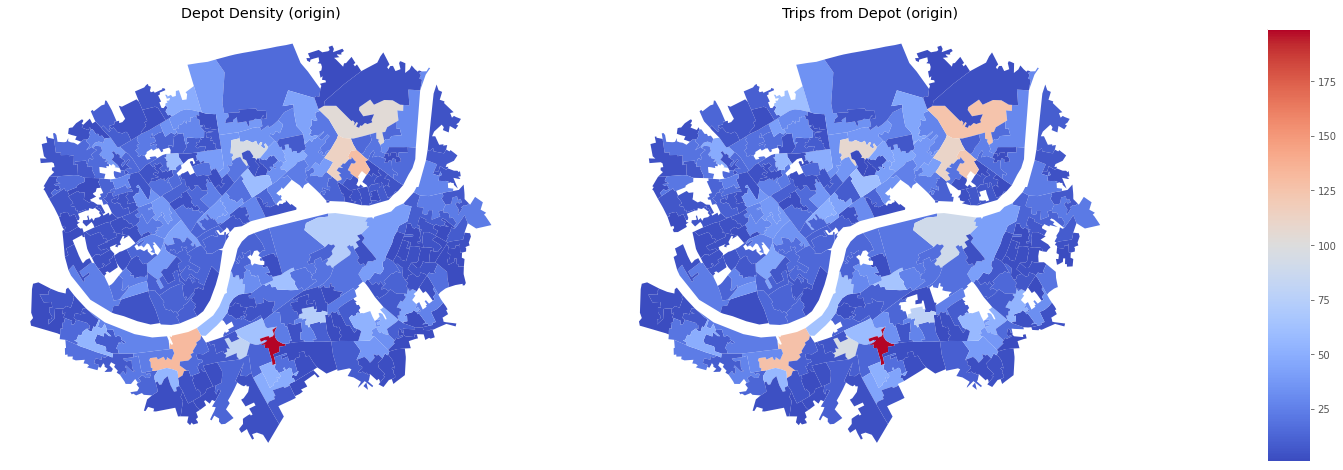

In [34]:
freight_density.plot_validate_spatial_density(title_1='Depot Density (origin)',
                                              title_2='Trips from Depot (origin)',
                                              density_metric='depot_density',
                                              density_trips='origin_trips'
                                              )

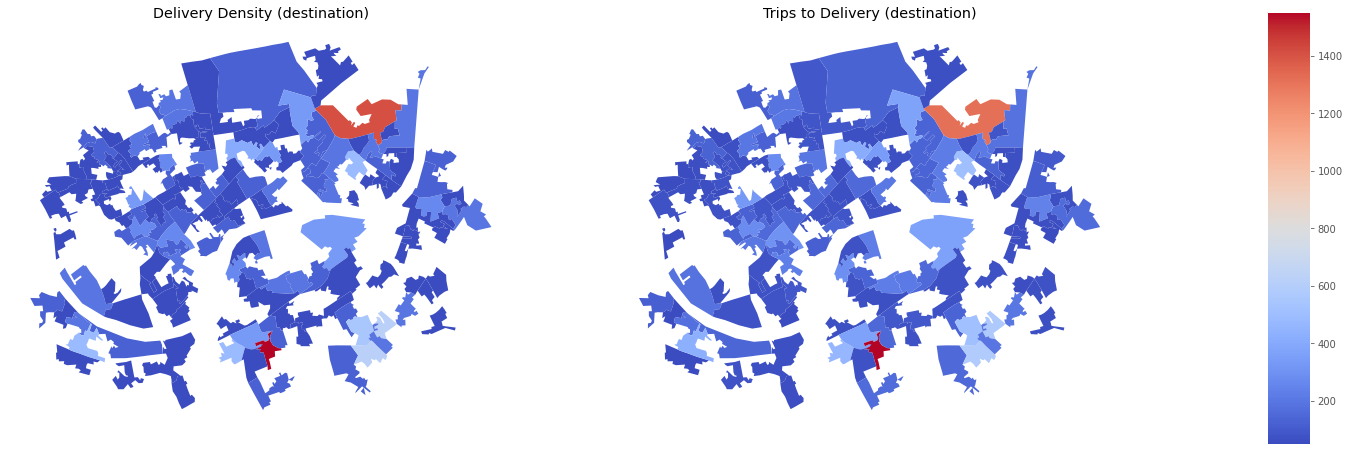

In [35]:
freight_density.plot_validate_spatial_density(title_1='Delivery Density (destination)',
                                              title_2='Trips to Delivery (destination)',
                                              density_metric='delivery_density',
                                              density_trips='destination_trips'
                                              )

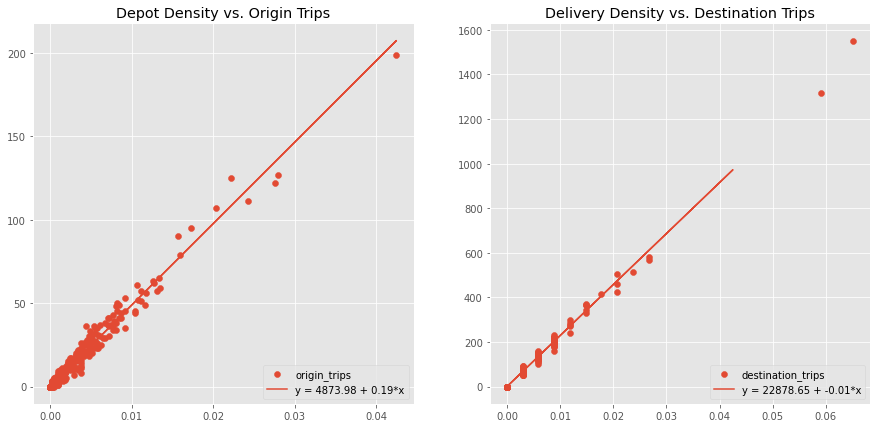

In [36]:
freight_density.plot_compare_density(title_1='Depot Density vs. Origin Trips',
                                     title_2='Delivery Density vs. Destination Trips',
                                     o_activity='depot_density',
                                     d_activity='delivery_density')